In [7]:
# For ucloud
#%pip install scikit-learn
#%pip install keras
#%pip install tensorflow
#%pip install seaborn

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Load the dataset
df = pd.read_csv("../data/heloc_dataset_v1.csv")
print("Initial shape:",df.shape)

# Label encode the target variable
labelencoder = LabelEncoder()
df["RiskPerformance"] = labelencoder.fit_transform(df["RiskPerformance"])

# Remove outliers using IQR - note how this method removes a lot of outliers, too many perhaps
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_outliers = df[((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
df_clean = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

print("Cleaned df:", df_clean.shape,", Outliers:",df_outliers.shape)


Initial shape: (10459, 24)
Cleaned df: (4004, 24) , Outliers: (6455, 24)


In [4]:
# Keeping both clean and outlier to test out different models on each 

# Normalize clean df
scaler = MinMaxScaler()
df_clean = df_clean.copy()
df_clean.iloc[:, :-1] = scaler.fit_transform(df_clean.iloc[:, :-1])

# Normalize outlier df
df_outliers = df_outliers.copy()
df_outliers.iloc[:, :-1] = scaler.fit_transform(df_outliers.iloc[:, :-1])


This block uses the LabelEncoder class from scikit-learn to convert the target variable, RiskPerformance, from a categorical format (e.g., 'Good', 'Bad') to numerical format (e.g., 0, 1). This is necessary because most machine learning algorithms work with numerical data.

Then it calculates the first (Q1) and third (Q3) quartiles for each column in the DataFrame, computes the Interquartile Range (IQR = Q3 - Q1), and removes rows where any feature has a value outside the range (Q1 - 1.5 * IQR) to (Q3 + 1.5 * IQR). This step is done to eliminate potential outliers that could negatively affect the performance of the models.

At the end it normalizes the feature columns by scaling their values to a range of [0, 1] using the MinMaxScaler class from scikit-learn. This is done to ensure that all features are on the same scale, which can improve the performance of some machine learning algorithms.

In [5]:
# Specifcy which df to use
df = df_clean.copy()
df.shape

(4004, 24)

In [6]:
df

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
2,0,0.413043,0.162996,0.217391,0.129032,0.166667,0.0,0,1.00000,0.018868,...,0.538462,0.380952,0.8,0.8,0.476562,0.362745,0.444444,0.2,0.5,86
7,1,0.434783,0.343612,0.304348,0.393548,0.333333,0.0,0,0.46875,0.735849,...,0.538462,0.380952,0.0,0.0,0.281250,0.274510,0.222222,0.2,1.0,40
10,1,0.739130,0.229075,0.217391,0.277419,0.312500,0.0,0,1.00000,0.018868,...,0.371795,0.380952,0.0,0.0,0.179688,0.470588,0.444444,0.2,0.0,67
12,0,0.565217,0.621145,0.086957,0.400000,0.458333,0.0,0,1.00000,0.018868,...,0.474359,0.380952,0.4,0.4,0.203125,0.357843,0.333333,0.8,0.5,67
16,0,0.282609,0.581498,0.826087,0.412903,0.270833,0.0,0,0.59375,0.150943,...,0.397436,0.380952,0.4,0.2,0.546875,0.372549,0.333333,0.4,0.5,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10449,1,0.195652,0.405286,0.173913,0.535484,0.354167,0.0,0,0.65625,0.188679,...,0.692308,0.571429,0.2,0.2,0.789062,0.392157,0.555556,0.4,0.5,100
10450,1,0.782609,0.707048,0.260870,0.638710,0.500000,0.0,0,1.00000,0.018868,...,0.282051,0.904762,0.0,0.0,0.140625,0.490196,0.444444,0.4,0.0,70
10451,1,0.673913,0.310573,0.086957,0.412903,0.541667,0.0,0,1.00000,0.018868,...,0.435897,0.380952,0.8,0.8,0.070312,0.495098,0.444444,0.2,0.0,60
10452,1,0.913043,0.451542,0.217391,0.567742,0.250000,0.0,0,1.00000,0.018868,...,0.564103,0.571429,0.4,0.4,0.101562,0.284314,0.333333,0.4,0.0,100


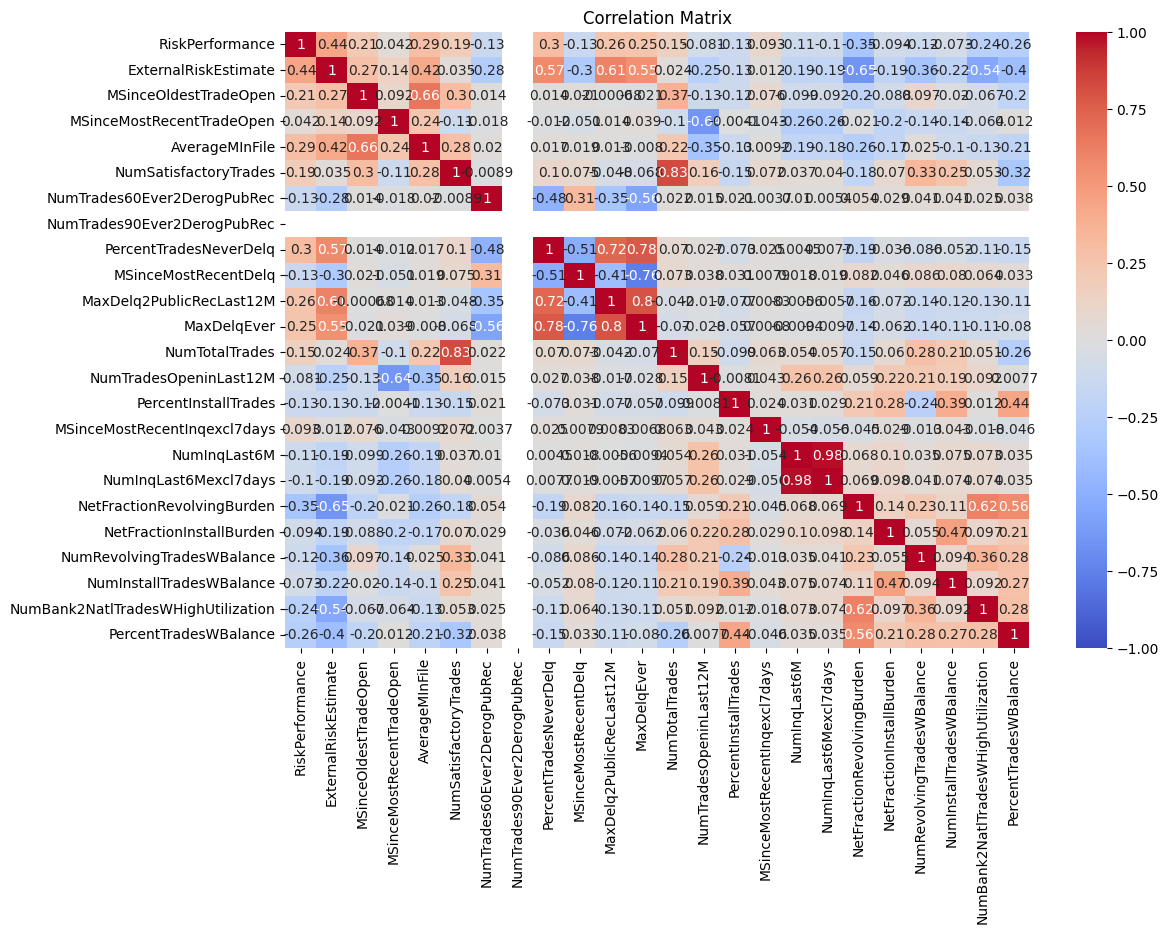

In [7]:
# compute the correlation matrix
corr_matrix = df.corr()

# plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


In [8]:
# Split the dataset into training and testing sets
y = df.loc[:, "RiskPerformance"]
X = df.drop(["RiskPerformance"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

This block splits the dataset into feature variables (X) and the target variable (y). It then further splits the data into training and testing sets (80% training, 20% testing) using the train_test_split function from scikit-learn. This is necessary to train the machine learning models on a portion of the data and evaluate their performance on unseen data to measure their ability to generalize.

In [9]:
# Evaluation function that prints classification report and confusion matrix
def evaluate(y_test, y_pred, model_name):
    #print accuracy
    print(f"\033[34m{model_name}\033[0m")
    print(f" \033[32mAccuracy:\033[0m {round(accuracy_score(y_test, y_pred),3)}")
    print()
    print(f" \033[32mClassification Report:\033[0m")
    print(classification_report(y_test, y_pred))
    print(f" \033[32mConfusion Matrix:\033[0m")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title(f'{model_name}: Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

Random Forest
 Accuracy: 0.753

 Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.70       335
           1       0.78      0.80      0.79       466

    accuracy                           0.75       801
   macro avg       0.75      0.74      0.74       801
weighted avg       0.75      0.75      0.75       801

 Confusion Matrix:


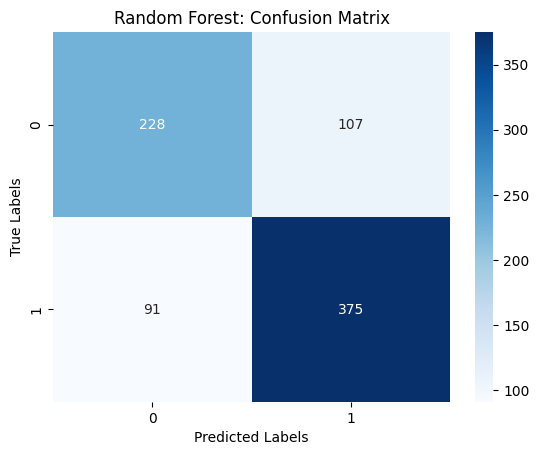

In [10]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=50, max_leaf_nodes=30, random_state=68)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate the rf
evaluate(y_test, y_pred_rf, "Random Forest")

## Trying out permutation importance to remove features

Discarded Features:  ['NumTrades90Ever2DerogPubRec']
Random Forest Classifier
 Accuracy: 0.762

 Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       335
           1       0.79      0.80      0.80       466

    accuracy                           0.76       801
   macro avg       0.76      0.75      0.75       801
weighted avg       0.76      0.76      0.76       801

 Confusion Matrix:


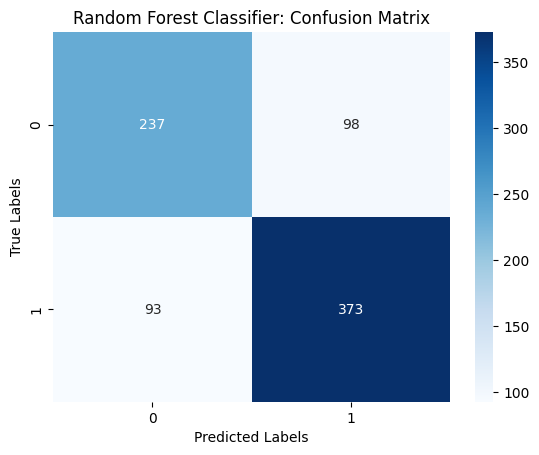

In [11]:
from sklearn.inspection import permutation_importance

def run_permutation_importance_and_get_important_features(X_train, y_train, X_test, model):
    # Fit the model and compute permutation importance
    model.fit(X_train, y_train)
    result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
    importance = result.importances_mean

    # Get important features
    important_indices = np.where(importance > 0)
    
    unimportant_features = [col for i, col in enumerate(X_train.columns) if i not in important_indices[0]]
    print("Discarded Features: ", unimportant_features)

    X_train_important = X_train[X_train.columns[important_indices]]
    X_test_important = X_test[X_test.columns[important_indices]]
    
    return X_train_important, X_test_important, model

# Initialize the model
model = RandomForestClassifier(n_estimators=50, max_leaf_nodes=30, random_state=42)

# Get important features and retrained model
X_train_important, X_test_important, model = run_permutation_importance_and_get_important_features(X_train, y_train, X_test, model)


# Retrain the model on the important features
RF_model_important = RandomForestClassifier(random_state=42)
RF_model_important.fit(X_train_important, y_train)

# Predict the target variable for the test set and evaluate its accuracy
y_pred = RF_model_important.predict(X_test_important)

evaluate(y_test, y_pred, "Random Forest Classifier")


This block creates a Random Forest classifier, trains it on the training data, and generates predictions for the test data. Random Forest is an ensemble learning method that fits multiple decision trees and combines their predictions to improve the overall performance and control overfitting.

## Fitting a simple NN

2023-05-12 10:34:00.210238: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


26/26 [==============================] - 0s 363us/step
Neural Network
 Accuracy: 0.744

 Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.57      0.65       335
           1       0.74      0.87      0.80       466

    accuracy                           0.74       801
   macro avg       0.75      0.72      0.72       801
weighted avg       0.75      0.74      0.74       801

 Confusion Matrix:


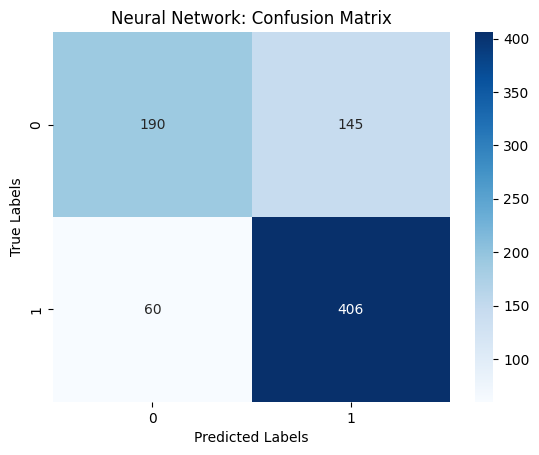

In [12]:
# Simple Neural Network
NN_simple_model = Sequential()
NN_simple_model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
NN_simple_model.add(Dropout(0.5))
NN_simple_model.add(Dense(128, activation='relu'))
NN_simple_model.add(Dropout(0.4))
NN_simple_model.add(Dense(64, activation='relu'))
NN_simple_model.add(Dropout(0.3))
NN_simple_model.add(Dense(1, activation='sigmoid'))

# Compile the model
NN_simple_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
NN_simple_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

# Predict with the model
y_pred_nn = (NN_simple_model.predict(X_test) > 0.5).astype("int32")

evaluate(y_test, y_pred_nn, "Neural Network")

## Fitting an (overly) complex NN

26/26 [==============================] - 0s 453us/step
Neural Network
 Accuracy: 0.734

 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.50      0.61       335
           1       0.71      0.90      0.80       466

    accuracy                           0.73       801
   macro avg       0.75      0.70      0.70       801
weighted avg       0.75      0.73      0.72       801

 Confusion Matrix:


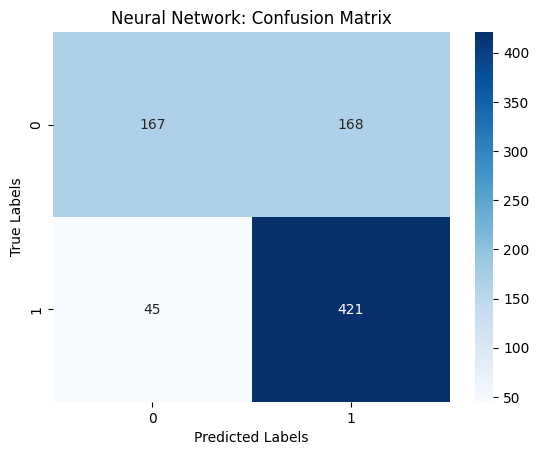

In [13]:
# Complex Neural Network
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Define the model
model = Sequential()

# Add input layer and first hidden layer
model.add(Dense(units=256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(rate=0.5))

# Add second hidden layer
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.5))

# Add third hidden layer
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.5))

# Add fourth hidden layer
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.5))

# Add fifth hidden layer
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(rate=0.5))

# Add output layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

# Make predictions on the test data
y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")

evaluate(y_test, y_pred_nn, "Neural Network")


This block defines, compiles, and trains a simple neural network using the Keras library. The neural network has two hidden layers with ReLU activation functions and dropout for regularization. The output layer has a sigmoid activation function for binary classification. The model is compiled using the Adam optimizer and binary cross-entropy loss, and trained for 100 epochs with a batch size of 64.

Logistic Regression
 Accuracy: 0.749

 Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.67      0.69       335
           1       0.77      0.81      0.79       466

    accuracy                           0.75       801
   macro avg       0.74      0.74      0.74       801
weighted avg       0.75      0.75      0.75       801

 Confusion Matrix:


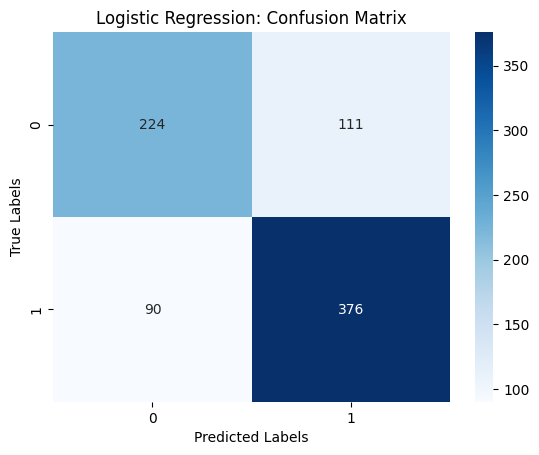

In [14]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluation
evaluate(y_test, y_pred_lr, "Logistic Regression")

# Added Freds SVM Model

In [15]:
# Fitting our SVM Classifier
from sklearn.svm import LinearSVC



svmTuned = LinearSVC(max_iter = 1000000, loss = 'hinge', C = 1, random_state = 9)
svmTuned.fit(X_train, y_train)

/Users/davidbellenberg/anaconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1, loss='hinge', max_iter=1000000, random_state=9)

# Voting with threshold
### Added by David

1. Obtain the probabilities for each model's predictions on a given sample.
2. Apply the threshold to determine if a model's predicted probability is above 70%.
3. Count the number of models whose predicted probability exceeds the threshold.
4. Make the final prediction based on the voting results.

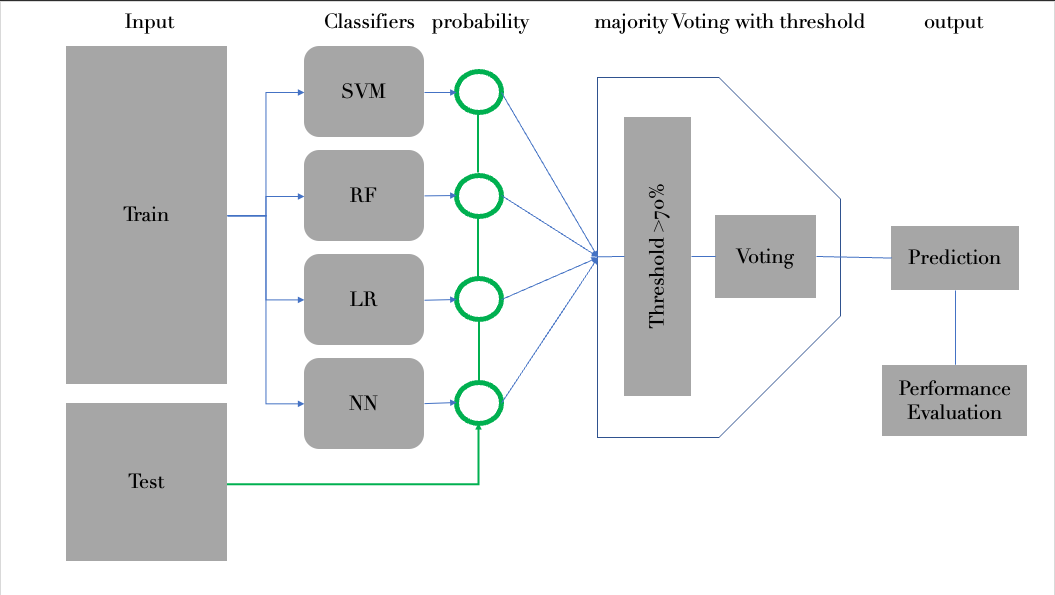

### Research/ Related Work


https://www.tandfonline.com/doi/full/10.1080/01605682.2019.1705193



In [36]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Function that uses multiple models to vote on the classification of a sample
def voting_function(models, sample, threshold):
    votes = 0  # Variable to count the votes
    model_votes = []  # List to store the probabilities from models that voted

    # Iterate over each model
    for model in models:
        # Check if the model has a "predict_proba" method
        if hasattr(model, "predict_proba"):
            probabilities = model.predict_proba(sample)  # Get predicted probabilities
            # because different models return differnet shapes of theit probabilities output we need to check the shape
            # If probabilities is a 1D array
            if probabilities.ndim == 1:
                predicted_probability = probabilities[1]  # Assume binary classification
            else:  # If probabilities is a 2D array ( in teh case for LogisticRegression)
                predicted_probability = probabilities[0, 1]  # Assume binary classification

        # Check if the model has a "decision_function" method
        elif hasattr(model, "decision_function"):
            predicted_score = model.decision_function(sample)  # Get decision function score
            predicted_probability = sigmoid(predicted_score)  # Apply sigmoid function to convert score to a probability
            # If predicted_probability is a 1D array
            if predicted_probability.ndim == 1 and len(predicted_probability) == 1:
                predicted_probability = predicted_probability[0]  # Convert to scalar
            elif predicted_probability.ndim > 1:
                predicted_probability = predicted_probability[0, 1]  # Assume binary classification

    
        else:
            # If the model has an output_shape attribute with more than one dimension and the second dimension is 1
            if len(model.output_shape) > 1 and model.output_shape[1] == 1:
                predicted_probabilities = model.predict(sample)  # Get predicted probabilities
                predicted_probability = predicted_probabilities[0, 0]  # Assume binary classification
            else:  # If the model doesn't have an output_shape attribute with more than one dimension and the second dimension is 1
                predicted_probabilities = model.predict(sample)  # Get predicted probabilities
                predicted_probability = predicted_probabilities[0, 1]  # Assume binary classification

        # If the predicted probability is greater than the threshold
        if predicted_probability > threshold:
            votes += 1  # Increase the votes count
        
        model_votes.append((model, predicted_probability))  # Add the model and its predicted probability to the list of model votes

    # If the number of votes is greater than half the number of models
    if votes > len(models) / 2:
        prediction = 1  # Predict the positive class
    else:
        prediction = 0  # Predict the negative class

    return prediction, model_votes  # Return the prediction and the votes of the models that voted


# Define the models
models = [svmTuned, lr, rf, NN_simple_model]
sample = X_test.iloc[3]  # Select the first sample from the test set
threshold = 0.7  # Set the probability threshold

# Use the voting function to predict the class of the sample
prediction, model_votes = voting_function(models, sample.values.reshape(1, -1), threshold)


# Create an empty list to store the rows of the table
table_rows = []

# Loop over the model votes
for model, predicted_probability in model_votes:
    # Create a dictionary for this row
    row = {
        "Model": model.__class__.__name__,
        "Probability": predicted_probability
    }
    # Add the dictionary to the list
    table_rows.append(row)

# Create a DataFrame from the list of dictionaries
votes_table = pd.DataFrame(table_rows)

#print fstring for threshold
print(f"Threshold: {threshold}")

# Display the final prediction and the table
print("Model Votes:")
print(votes_table)



print("Final Prediction:", prediction)



1/1 [==============================] - 0s 11ms/step
Threshold: 0.7
Model Votes:
                    Model  Probability
0               LinearSVC     0.743282
1      LogisticRegression     0.754933
2  RandomForestClassifier     0.696086
3              Sequential     0.703043
Final Prediction: 1


/Users/davidbellenberg/anaconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/Users/davidbellenberg/anaconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/davidbellenberg/anaconda3/envs/ml_env/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [43]:
import pandas as pd

# Define a function to apply the color
def color_above_threshold(val):
    color = 'green' if val > threshold else 'red'
    return f'color: {color}'

# Create an empty list to store the rows of the table
table_rows = []

# Loop over the model votes
for model, predicted_probability in model_votes:
    # Create a dictionary for this row
    row = {
        "Model": model.__class__.__name__,
        "Probability": predicted_probability
    }
    # Add the dictionary to the list
    table_rows.append(row)

# Create a DataFrame from the list of dictionaries
votes_table = pd.DataFrame(table_rows)

#print fstring for threshold
print(f"Threshold: {threshold}")
# Display the final prediction and the table
print("Model Votes:")

# Apply the color to the 'Probability' column
styled_table = votes_table.style.applymap(color_above_threshold, subset=['Probability'])

display(styled_table)

print("Final Prediction:", prediction)


Threshold: 0.7
Model Votes:


,Model,Probability
0,LinearSVC,0.743282
1,LogisticRegression,0.754933
2,RandomForestClassifier,0.696086
3,Sequential,0.703043


Final Prediction: 1


In [44]:
import warnings

# Filter out the specific warning
warnings.filterwarnings("ignore", message="X does not have valid feature names")


# Select 100 random examples from the test set
random_indices = np.random.choice(X_test.shape[0], size=100, replace=False)
random_examples = X_test.iloc[random_indices]
actual_classes = y_test.iloc[random_indices]

# Initialize counters
predicted_ones = 0
actual_ones = 0
exspensive_mistake = 0

# Apply the voting function to each random example
for i, example in random_examples.iterrows():
    prediction, _ = voting_function(models, example.values.reshape(1, -1), threshold)

    print("Example:", i)
    print("Prediction:", prediction)
    print("Actual Class:", actual_classes[i])
    print()

    if prediction == 1:
        predicted_ones += 1

        if actual_classes[i] == 0:
            exspensive_mistake += 1

    if actual_classes[i] == 1:
        actual_ones += 1

print(f"{predicted_ones} credit application where approved, of which {exspensive_mistake} shouldn't have been approved. {actual_ones} could have been approaved in total")


# Reset the warnings filter to the default state
warnings.filterwarnings("default")

1/1 [==============================] - 0s 11ms/step
Example: 7245
Prediction: 0
Actual Class: 0

1/1 [==============================] - 0s 12ms/step
Example: 2761
Prediction: 0
Actual Class: 0

1/1 [==============================] - 0s 10ms/step
Example: 5145
Prediction: 0
Actual Class: 0

1/1 [==============================] - 0s 11ms/step
Example: 1610
Prediction: 1
Actual Class: 1

1/1 [==============================] - 0s 11ms/step
Example: 5139
Prediction: 0
Actual Class: 0

1/1 [==============================] - 0s 10ms/step
Example: 8295
Prediction: 0
Actual Class: 0

1/1 [==============================] - 0s 10ms/step
Example: 8899
Prediction: 0
Actual Class: 0

1/1 [==============================] - 0s 10ms/step
Example: 10333
Prediction: 0
Actual Class: 1

1/1 [==============================] - 0s 9ms/step
Example: 916
Prediction: 1
Actual Class: 1

1/1 [==============================] - 0s 10ms/step
Example: 10320
Prediction: 1
Actual Class: 1

1/1 [=========================

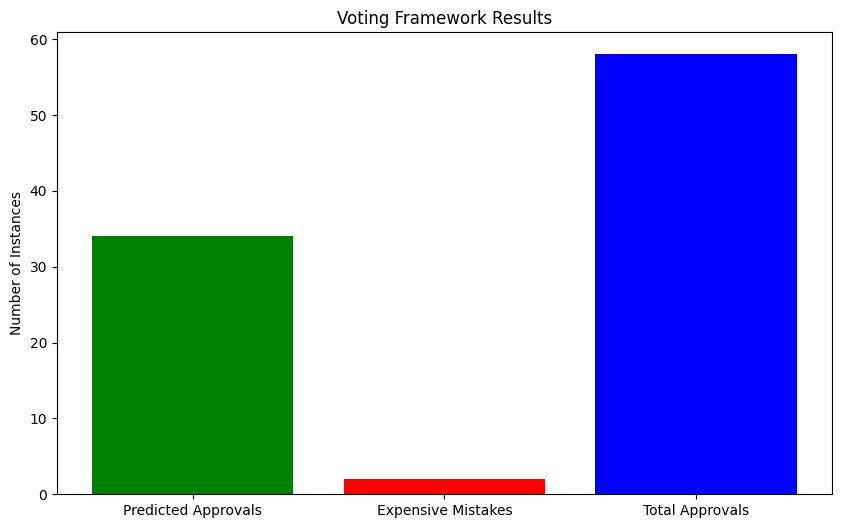

In [129]:
import matplotlib.pyplot as plt

# Prepare data for the bar chart
labels = ['Predicted Approvals', 'Expensive Mistakes', 'Total Approvals']
values = [predicted_ones, exspensive_mistake, actual_ones]

# Create bar chart
plt.figure(figsize=(10,6))
plt.bar(labels, values, color=['green', 'red', 'blue'])
plt.title('Voting Framework Results')
plt.ylabel('Number of Instances')
plt.show()


## Gridsearch for LR

In [ ]:
import warnings

# Suppress the warning message for non-finite test/train scores
warnings.filterwarnings('ignore', message='One or more of the test scores are non-finite')
warnings.filterwarnings('ignore', message='One or more of the train scores are non-finite')

from sklearn.experimental import enable_halving_search_cv
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import HalvingGridSearchCV

# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'penalty': ['none', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [100, 500, 5000, 50000]
}


# Initialize the Logistic Regression classifier
lr = LogisticRegression()

# Set up the HalvingGridSearchCV
grid_search_lr = HalvingGridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, n_jobs=-1, verbose=2, factor=2, min_resources='exhaust')

# Fit the HalvingGridSearchCV to the data
grid_search_lr.fit(X_train, y_train)

# Get the best parameters
best_params_lr = grid_search_lr.best_params_
print("Best parameters for Logistic Regression:", best_params_lr)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression
 Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.67      0.70       335
         1.0       0.78      0.81      0.79       466

    accuracy                           0.76       801
   macro avg       0.75      0.74      0.75       801
weighted avg       0.75      0.76      0.75       801

 Confusion Matrix:


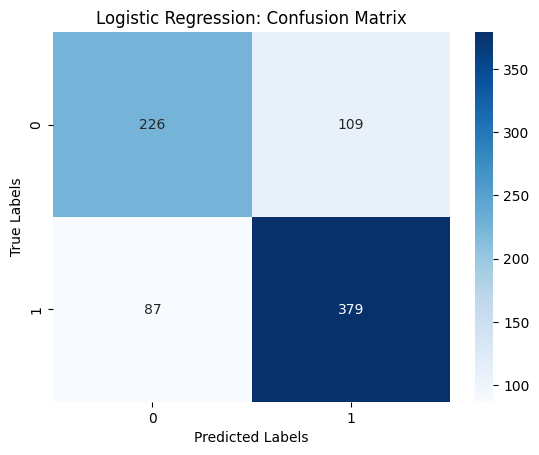

In [ ]:
lr = LogisticRegression(**best_params_lr)

lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluation
evaluate(y_test, y_pred_lr, "Logistic Regression")

## Gridsearch for RF

In [ ]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import HalvingGridSearchCV

# Define the parameter grid for the Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Set up the HalvingGridSearchCV
grid_search_rf = HalvingGridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2, factor=2, min_resources='exhaust')

# Fit the HalvingGridSearchCV to the data
grid_search_rf.fit(X_train, y_train)

# Get the best parameters
best_params_rf = grid_search_rf.best_params_
print("Best parameters for Random Forest:", best_params_rf)


n_iterations: 8
n_required_iterations: 10
n_possible_iterations: 8
min_resources_: 20
max_resources_: 3203
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 864
n_resources: 20
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
----------
iter: 1
n_candidates: 432
n_resources: 40
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
----------
iter: 2
n_candidates: 216
n_resources: 80
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
----------
iter: 3
n_candidates: 108
n_resources: 160
Fitting 5 folds for each of 108 candidates, totalling 540 fits
----------
iter: 4
n_candidates: 54
n_resources: 320
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 5
n_candidates: 27
n_resources: 640
Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [ ]:
from sklearn.metrics import classification_report

# Use the best estimator to make predictions on the test data
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)

# Print the classification report for the Random Forest Classifier
print("Classification Report for Random Forest Classifier:")
print(classification_report(y_test, y_pred_rf))


# Gridsearch for NN

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import HalvingGridSearchCV

# Function to create model, required for KerasClassifier
def build_nn(dropout_rate=0.5, neurons=256):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(int(neurons/2), activation='relu'))
    model.add(Dropout(dropout_rate*0.8))
    model.add(Dense(int(neurons/4), activation='relu'))
    model.add(Dropout(dropout_rate*0.6))
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create model
model = KerasClassifier(build_fn=build_nn, verbose=0)

# Define the grid search parameters
param_grid = {
    'batch_size': [10, 40, 80, 100],
    'epochs': [20, 50, 100],
    'dropout_rate': [0.1, 0.3, 0.5, 0.7],
    'neurons': [64, 128, 256]
}

# Create Halving Grid Search
halving_grid = HalvingGridSearchCV(estimator=model, param_grid=param_grid, cv=3, factor=3)
halving_grid_result = halving_grid.fit(X_train, y_train)

# Report Results
print(f"Best: {halving_grid_result.best_score_} using {halving_grid_result.best_params_}")



In [ ]:
best_params_nn = halving_grid_result.best_params_

# Train the model with best parameters
model = KerasClassifier(build_fn=build_nn, **best_params_nn, verbose=0)
model.fit(X_train, y_train)

# Predict with the model
y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")
evaluate(y_test, y_pred_nn, "Neural Network")


# Ensemble model

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.models import Sequential
from keras.layers import Dense

# Wrap Keras model so it can be used by scikit-learn
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, **kwargs):
        self.build_fn = build_fn
        self.kwargs = kwargs
    def fit(self, X, y):
        self.model_ = self.build_fn(**self.kwargs)
        optimizer = Adam(learning_rate=0.001)
        self.model_.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        self.model_.fit(X, y, verbose=0)
        return self
    def predict(self, X):
        return (self.model_.predict(X) > 0.5).astype("int32")
    def predict_proba(self, X):
        probabilities = self.model_.predict(X)
        return np.hstack([1 - probabilities, probabilities])


# Build function for the Keras model
def build_nn():
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model


# Create the ensemble model
rf = RandomForestClassifier(**best_params_rf)
lr = LogisticRegression(**best_params_lr)
nn = KerasClassifierWrapper(build_nn, **best_params_nn)

voting_clf = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('nn', nn)], voting='soft')
voting_clf.fit(X_train, y_train)

# Predictions
y_pred = voting_clf.predict(X_test)

# Evaluation
evaluate(y_test, y_pred, "Voting Classifier")


In [ ]:
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Create a list of all models
models = [lr, rf, nn]

# Create a list to store the best score and ensemble
best_score = 0
best_ensemble = None

# Loop over all possible combinations of models
for r in range(1, len(models) + 1):
    for subset in combinations(models, r):
        subset = list(subset)
        ensemble = VotingClassifier(estimators=[(type(model).__name__, model) for model in subset], voting='soft')
        ensemble.fit(X_train, y_train)
        predictions = ensemble.predict(X_test)
        score = accuracy_score(y_test, predictions)
        
        if score > best_score:
            best_score = score
            best_ensemble = ensemble

print("Best ensemble:")
print(best_ensemble)
print("Best ensemble score:")
print(best_score)
